# Model creation

Use this notebook to create a model using a specific method

- [Polynomial regression](#polynomial-regression)
- [Gradient boosted decision trees](#gradient-boosted-decision-trees)

# Setup

In [4]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import tools.common_functions as cf

import importlib

importlib.reload(cf)

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
ARRAY_SIZE = ARRAY_W * ARRAY_H
NAME_PREFIX = lambda i: f"H1_5-s{i}-20231218-005"
MODEL_NAME = "H1_5-2x2-005"
# NAMES = [f"H1_5_s{i}" for i in range(ARRAY_SIZE)]


In [5]:
NAMES = [f"{NAME_PREFIX(i)}" for i in range(ARRAY_SIZE)]
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

all_data = []

# Loading data (but not in 1 pd.DataFrame)
for i, name in enumerate(NAMES):
    TFdata = cf.read_csv_file(f"../data/raw/TF/{name}.csv") 
    sensordata = cf.read_csv_file(f'../data/raw/sensor/{name}.csv')
    
    # Time sync
    data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

    # Remove mean of first 100 samples
    data = cf.offset_data(data, data_columns, 100)
    
    # Remove rows containing NaN values
    data = data.dropna()
    
    # Add X, Y, Z columns to avoid confusion
    data['X'] = (data[f'X{i}'])
    data['Y'] = (data[f'Y{i}'])
    data['Z'] = (data[f'Z{i}'])
    
    # Remove other columns
    data = data.drop(columns=data_columns)

    all_data.append(data)

print("Data loaded. Taxel 0 sensor test")
all_data[0].info()

Data loaded. Taxel 0 sensor test
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17514 entries, 1 to 17514
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    17514 non-null  int64  
 1   t_wall   17514 non-null  float64
 2   t_robot  17514 non-null  float64
 3   F_x      17514 non-null  float64
 4   F_y      17514 non-null  float64
 5   F_z      17514 non-null  float64
 6   T_x      17514 non-null  float64
 7   T_y      17514 non-null  float64
 8   T_z      17514 non-null  float64
 9   X        17514 non-null  float64
 10  Y        17514 non-null  float64
 11  Z        17514 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.7 MB


In [6]:
for j in range(ARRAY_SIZE):
    data = all_data[j]
    
    data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
    data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)
    
    data[f'XY'] = np.sqrt(data[f'X']**2 + data[f'Y']**2)
    data[f'M'] = np.sqrt(data[f'X']**2 + data[f'Y']**2 + data[f'Z']**2)

In [7]:
def simulate_forces(taxel_models):
  # Simulate forces to plot model

  for j, letter in enumerate(['X', 'Y', 'Z']):

      fig = plt.figure()
      gs = fig.add_gridspec(ARRAY_H, ARRAY_W)
      axs = cf.flatten_extend(gs.subplots())

      for i, model in enumerate(taxel_models):

          data = all_data[i]

          ax = axs[i]
          
          X = data[['X', 'Y', 'Z']].to_numpy()
          Y = model.predict(X)

          ax.scatter(data[letter], data[f'F_{letter.lower()}'], label='Data', s=0.1, c='r')
          ax.scatter(X[:, j], Y[:, j], label='Model Function', s=0.1, alpha=0.5)
          

      plt.show()


In [8]:
# Save taxel models (per taxel)
import dill

def save_taxel_models(taxel_models, subdir, name):
  save_path = os.path.join(os.getcwd(), '..', 'models', subdir)

  if not os.path.exists(save_path):
      os.makedirs(save_path)
      
  with open(os.path.join(save_path, name), 'wb') as f:
      dill.dump(taxel_models, f)
    

# Polynomial regression

Calibration achieved by pressing on all taxel one-by-one without silicone layer

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

set_config(display='diagram')

COUPLE_COMPONENTS = True
POLY_DEGREE = 4

def create_regression_pipeline_and_fit(X, Y, debug = True):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

  pipeline = make_pipeline(
    PolynomialFeatures(degree=POLY_DEGREE, include_bias=False), 
    LinearRegression()
  )
  
  pipeline.fit(X_train, y_train)

  if debug:
    
    print("Score: ", pipeline.score(X_test, y_test))
    print("MSE: ", mean_squared_error(y_test, pipeline.predict(X_test)))
  
  return pipeline

class CombinedModel:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X[:, i].reshape(-1, 1))[:, 0])
    
    return np.array(predictions).T

In [10]:
taxel_models = []

for i in range(ARRAY_SIZE):

    data = all_data[i]
    
    if not COUPLE_COMPONENTS:
      component_models = []
      for letter in ['X', 'Y', 'Z']:
          
          print(f"\nTaxel {i}, {letter}")
          
          X = data[[letter]]
          Y = data[[f'F_{letter.lower()}']]
      
          print(Y.shape, X.shape)
      
          component_model = create_regression_pipeline_and_fit(X, Y)
          component_models.append(component_model)
      
      taxel_models.append(CombinedModel(component_models))
      
    else:
        print(f"\nTaxel {i}")
        
        X = data[['X', 'Y', 'Z']]
        Y = data[['F_x', 'F_y', 'F_z']]
        
        print(Y.shape, X.shape)
        
        component_model = create_regression_pipeline_and_fit(X, Y)
        taxel_models.append(component_model)


Taxel 0
(17514, 3) (17514, 3)
Score:  0.9730112888275709
MSE:  0.04408563461554962

Taxel 1
(12482, 3) (12482, 3)
Score:  0.9698019304669349
MSE:  0.03952169476415253

Taxel 2
(11390, 3) (11390, 3)
Score:  0.9717579726263837
MSE:  0.08635365012378883

Taxel 3
(9667, 3) (9667, 3)
Score:  0.9873930515817531
MSE:  0.04414246723042881


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


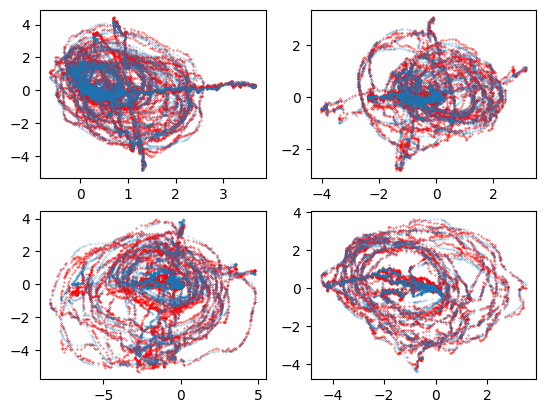

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


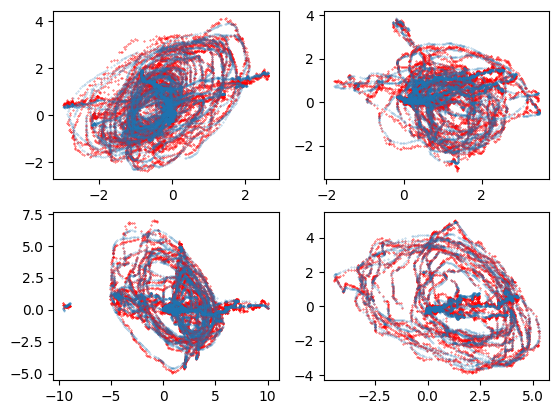

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


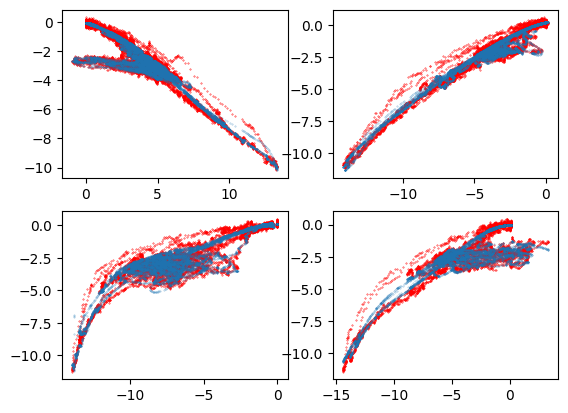

In [11]:
simulate_forces(taxel_models)

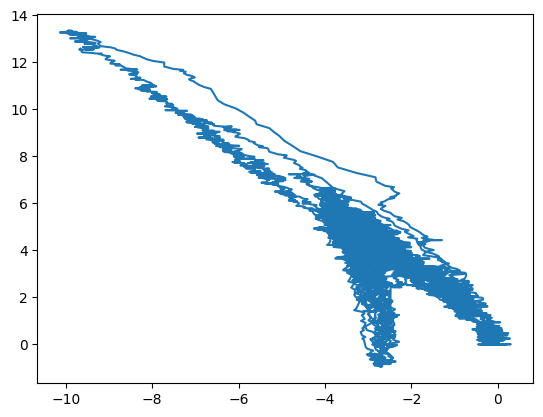

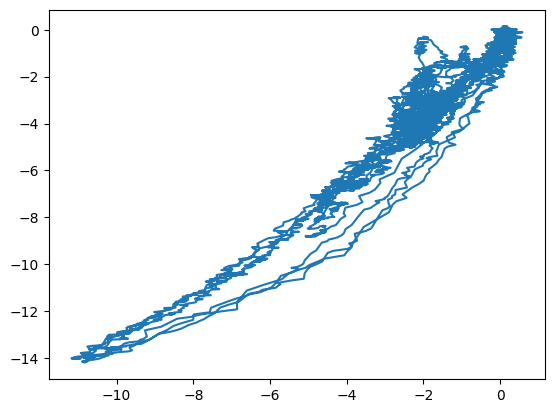

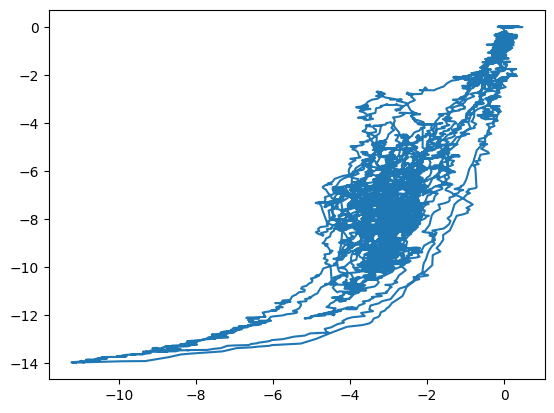

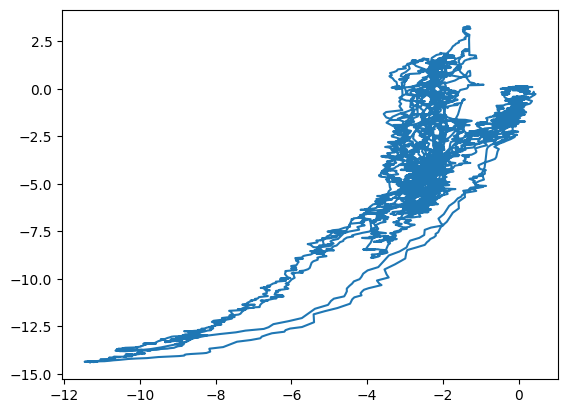

In [13]:
for i in range(ARRAY_SIZE):
  
  data = all_data[i]
  plt.plot(data['F_z'], data['Z'] )  
  plt.show()

In [82]:
save_taxel_models(taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME)

In [67]:
# Alternative thing
taxel_models = []

for i in range(ARRAY_SIZE):

    data = all_data[i]
        
    print(f"\nTaxel {i}, {letter}")
    
    X = data[['X', 'Y', 'Z']]
    Y = data[[f'F_x', f'F_y', f'F_z']]

    print(Y.shape, X.shape)

    model = create_regression_pipeline_and_fit(X, Y)
    
    taxel_models.append(model)


Taxel 0, Z
(17514, 3) (17514, 3)
Score:  0.9720991554762758
MSE:  0.04431442615547024

Taxel 1, Z
(12482, 3) (12482, 3)
Score:  0.9728806014269332
MSE:  0.03803582497258595

Taxel 2, Z
(11390, 3) (11390, 3)
Score:  0.9688490221696723
MSE:  0.10240261655736475

Taxel 3, Z
(9667, 3) (9667, 3)
Score:  0.9874805730292483
MSE:  0.04219849969226075


0
1
2
3


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


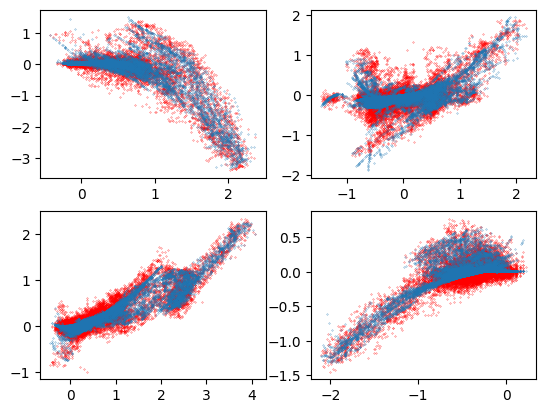

0
1
2
3


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


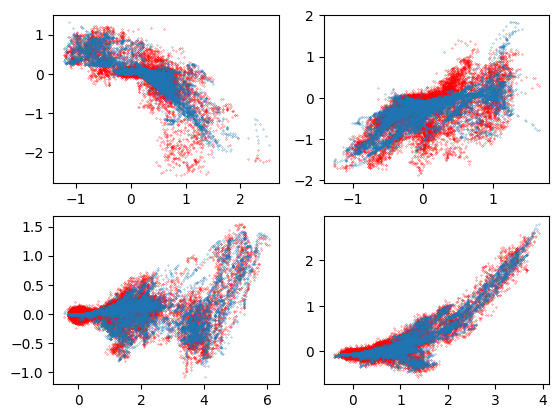

0
1
2
3


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


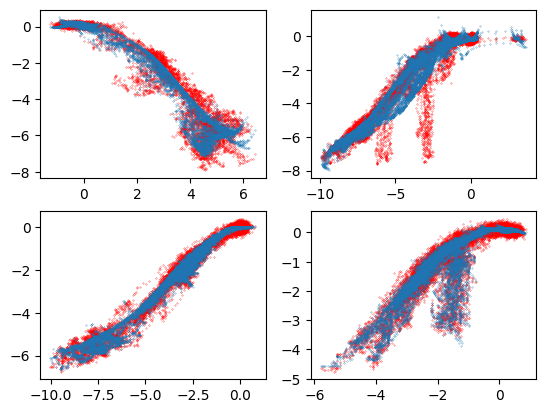

In [28]:
for j, letter in enumerate(['X', 'Y', 'Z']):

  fig = plt.figure()
  gs = fig.add_gridspec(ARRAY_H, ARRAY_W)
  axs = cf.flatten_extend(gs.subplots())

  for i, model in enumerate(taxel_models):

    print(i)
    data = all_data[i]

    ax = axs[i]
    
    # Simulate force
    X = np.zeros((100, 3))
    # X[:, j] = np.linspace(min(data[letter]), max(data[letter]), 100)
    
    Y = model.predict(data[['X', 'Y', 'Z']].to_numpy())

    
    ax.scatter(data[letter], data[f'F_{letter.lower()}'], label='Data', s=0.05, c='r')
    ax.scatter(data[[letter]].to_numpy()[:, 0], Y[:, j], label='Model Function', s=0.05)

  plt.show()


# Gradient boosted decision trees

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

In [7]:
class CombinedModelGDBT:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X))
    
    return np.array(predictions).T

In [23]:
taxel_models = []
columns = ['F_x', 'F_y', 'F_z']

param_grid = {
    "max_depth": [1, 2, 4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
}

for i in range(ARRAY_SIZE):
  
  data = all_data[i]
  
  component_models = []
  
  print(f"\nTaxel {i}")
  
  for col in columns:
    
    # (Train/val) / test split
    X = data[['X', 'Y', 'Z']]
    y = data[[col]]

    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=True)

    reg = HistGradientBoostingRegressor()

    gridsearch = GridSearchCV(reg, param_grid=param_grid, verbose=1, return_train_score=True, n_jobs=8)

    gridsearch.fit(X_train, y_train[:, 0])  
    
    print("Score: ", gridsearch.best_estimator_.score(X_test, y_test))
    
    component_models.append(gridsearch.best_estimator_)
    
  taxel_models.append(CombinedModelGDBT(component_models))


Taxel 0
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9284105770965261
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8207700205131018
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9786542057026573

Taxel 1
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8286420323327727
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8519166047225301
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9765049151303316

Taxel 2
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9404787098984293
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8868665554279788
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9941152256723282

Taxel 3
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8760352732550875
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.96

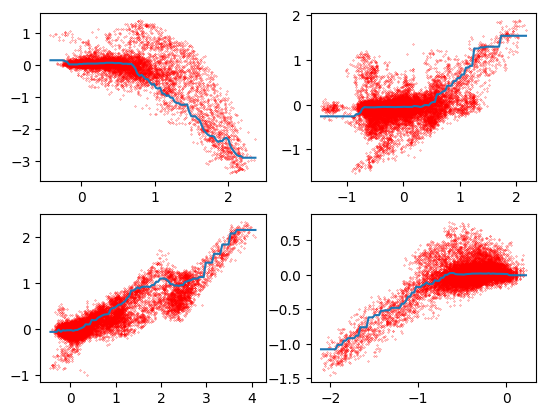

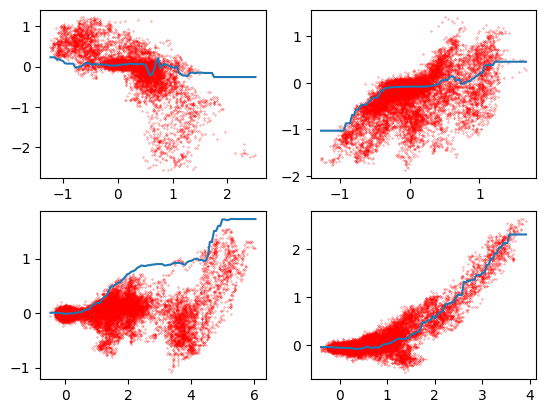

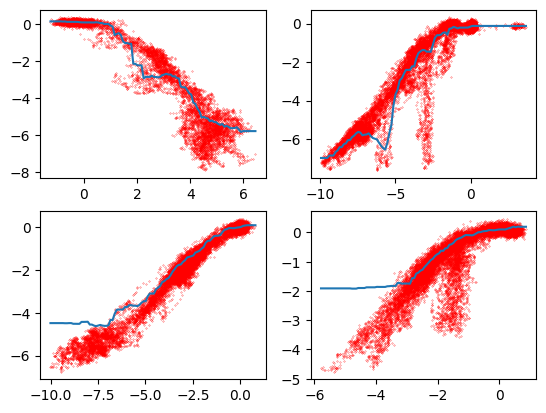

In [24]:
simulate_forces(taxel_models)

In [25]:
save_taxel_models(taxel_models, 'GBDT', MODEL_NAME)